# GPU Computing - Exercise 5

Eetu Knutars

11.2.2025

# Task 1
## Task 1a)
Compare the memory footprint of matrices in dense, COO and CSR -formats. Plot the amount of stored elements against the total number of elements in the matrix. Use sparse matrices with density of 0.01. Use different square matrix sizes to show the difference.

Hint: For COO and CSR formats you will have to find the sizes of vectors they store the data. Check out CuPy Sparse reference.



Import the libraries

In [20]:
import numpy as np
import cupy as cp
import scipy as sp
import cupyx as cpx
import matplotlib.pyplot as plt
import time
%matplotlib inline

Generate the data and compute the memory footprints

In [21]:
matrix_sizes = np.array([4,8,16,32,64,128,256,512])

A_coo_sizes = []
A_csr_sizes = []
A_dense_sizes = []

for matrix_size in matrix_sizes:

  # Build matrices and apply different formatting
  A_coo = cpx.scipy.sparse.rand(int(matrix_size), int(matrix_size))
  A_dense = A_coo.todense()
  A_csr = cpx.scipy.sparse.csr_matrix(A_coo)

  # Compute the sizes in memory
  A_csr_sizes.append(A_csr.data.size + A_csr.indices.size + A_csr.indptr.size)
  A_coo_sizes.append(A_coo.data.size + A_coo.row.size + A_coo.col.size)
  A_dense_sizes.append(A_dense.size)

Visualisation

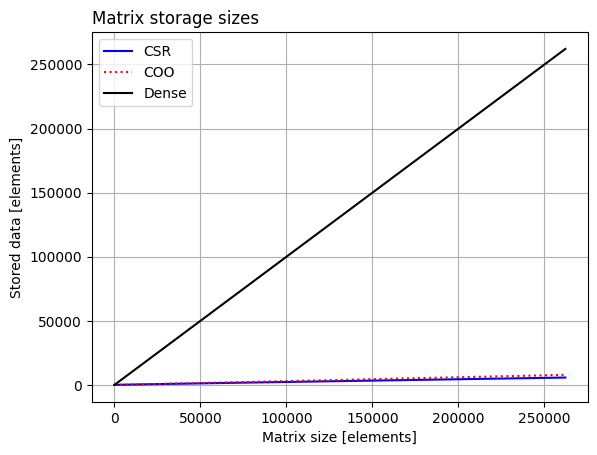

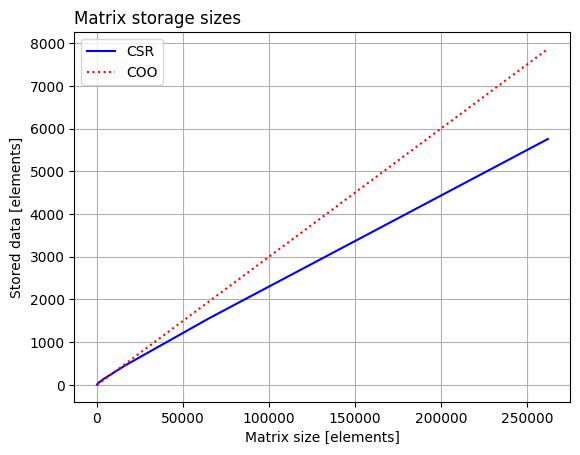

In [22]:
plt.figure
plt.plot(matrix_sizes**2, A_csr_sizes, label="CSR", color='b')
plt.plot(matrix_sizes**2, A_coo_sizes, label="COO", linestyle='dotted', color='r')
plt.plot(matrix_sizes**2, A_dense_sizes, label="Dense", color='k')

plt.grid()
plt.legend()
plt.title("Matrix storage sizes", loc='left')
plt.xlabel("Matrix size [elements]")
plt.ylabel("Stored data [elements]")
plt.show()

plt.figure
plt.plot(matrix_sizes**2, A_csr_sizes, label="CSR", color='b')
plt.plot(matrix_sizes**2, A_coo_sizes, label="COO", linestyle='dotted', color='r')

plt.grid()
plt.legend()
plt.title("Matrix storage sizes", loc='left')
plt.xlabel("Matrix size [elements]")
plt.ylabel("Stored data [elements]")
plt.show()

From the plots we can clearly see how much more efficient COO and CSR are compared to dense when it comes to storage space. COO and CSR require only a fraction of the space dense matrices need, which shows especially when the matrix size is big.

CSR is slightly more space efficient compared to COO, which makes sense since it uses more intelligent encoding and stores row pointers instead of row index for every element.

## Task 1b )
Compare the execution times of dot products between a matrix and a vector. Use four different cases for the matrix: Scipy dense, Scipy COO, CuPy dense and CuPy COO. The vector should be in dense-format in all cases.

Time their performance against different sizes of square matrices.

Why do the plots from a) and b) look the way they look? Which methods should be used when working on a GPU?

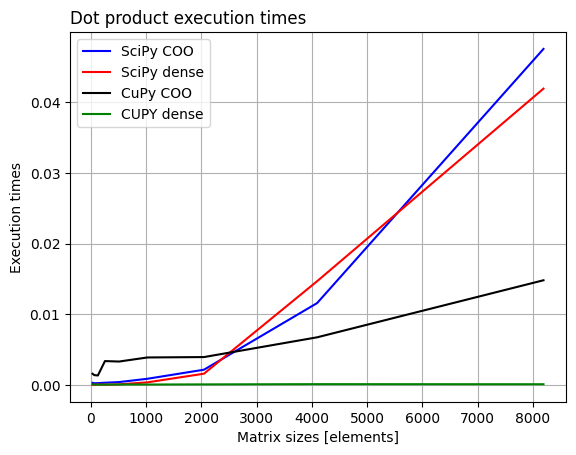

In [26]:
matrix_sizes = np.array([32,64,128,256,512, 1024, 2048, 4096, 8192])

sp_dense_times = []
sp_coo_times = []
cp_dense_times = []
cp_coo_times = []

for matrix_size in matrix_sizes:

  # Generating the matrices with different formatting
  cp_coo = cpx.scipy.sparse.rand(int(matrix_size), int(matrix_size))
  cp_dense = cp_coo.todense()
  sp_coo = sp.sparse.rand(int(matrix_size), int(matrix_size), format="coo")
  sp_dense = sp_coo.todense()

  cp_vec = cp.random.randn(matrix_size, 1)
  np_vec = np.random.randn(matrix_size, 1)


  start_time = time.time()
  cp_coo.multiply(cp_vec)
  cp_coo_times.append(time.time() - start_time)

  start_time = time.time()
  cp_dense @ cp_vec
  cp_dense_times.append(time.time() - start_time)

  start_time = time.time()
  sp_coo.multiply(np_vec)
  sp_coo_times.append(time.time() - start_time)

  start_time = time.time()
  sp_dense @ np_vec
  sp_dense_times.append(time.time() - start_time)

plt.plot(matrix_sizes, sp_coo_times, color='b')
plt.plot(matrix_sizes, sp_dense_times, color='r')
plt.plot(matrix_sizes, cp_coo_times, color='k')
plt.plot(matrix_sizes, cp_dense_times, color='g')

plt.grid()
# plt.legend()
plt.title("Dot product execution times", loc='left')
plt.xlabel("Matrix sizes [elements]")
plt.ylabel("Execution times")
plt.legend(["SciPy COO", "SciPy dense", "CuPy COO", "CUPY dense"], loc="best")

plt.show()

CuPy matrices perform better than SciPy matrices when the matrix size gets large, which makes sense since GPU computing can paralellize the computions. Dense matrices are faster than COO formated matrices, which is a bit surprising but can be explained by the simplicity of the dot product compution

# Task 2

Random numbers

Estimate the value of pi by random sampling. Implement by using both CuPy and Numpy and compare the execution time with million random points.

How to estimate pi:

1. Generate uniform random samples in 2D between -0.5 and 0.5.

2. Find their distance from (0,0).

3. Find how many of the samples have distance < 0.5.

4. Calculate the ratio of points inside the circle vs total number of points. Multiply by 4.

5. Enjoy the accurate estimation.

Importing libraries

In [24]:
import numpy as np
import cupy as cp
import time

Estimating $\pi$ with both NumPy and CuPy with $10^6$ data points

In [25]:
samples = 10**6

# NumPy
start_time = time.time()
samples_points = np.random.random((samples, 2)) - 0.5
samples_in_circle = np.sum(np.sqrt(samples_points[:, 0]**2 + samples_points[:, 1]**2) <= 0.5)
print("Execution time (NumPy):", time.time() - start_time)
print("Estimate for pi:", 4*samples_in_circle/samples)

# CuPy
start_time = time.time()
samples_points = cp.random.random((samples, 2)) - 0.5
samples_in_circle = cp.sum(cp.sqrt(samples_points[:, 0]**2 + samples_points[:, 1]**2) <= 0.5)
print("Execution time (CuPy):", time.time() - start_time)
print("Estimate for pi:", 4*samples_in_circle/samples)


Execution time (NumPy): 0.02199077606201172
Estimate for pi: 3.141168
Execution time (CuPy): 0.0026693344116210938
Estimate for pi: 3.142688
